In [1]:
import torch
import torch.nn as nn

In [2]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [4]:
from torchvision import datasets, transforms

data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [5]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [6]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [7]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

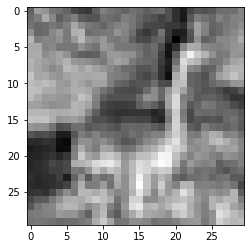

In [8]:
from matplotlib import pyplot as plt

plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

In [9]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

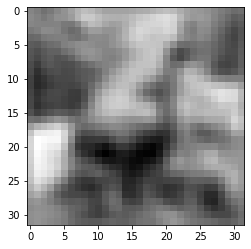

In [10]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0 / 9.0)

output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

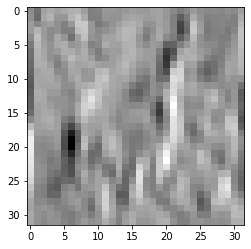

In [11]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    # (Vertical) Edge Detect Kernel
    conv.bias.zero_()
    
output = conv(img.unsqueeze(0))
plt.imshow(output[0][0].detach(), cmap='gray')
plt.show()

In [12]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [13]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # something missing here
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2),
)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # the missing one
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [15]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [16]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [17]:
model = Net()
model(img.unsqueeze(0))

tensor([[ 0.2421, -0.1438]], grad_fn=<AddmmBackward0>)

In [18]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
	for epoch in range(1, n_epochs + 1):
		loss_train = 0.0
		for imgs, labels in train_loader:
			imgs, labels = imgs.to('cuda'), labels.to('cuda')
			outputs = model(imgs)
			loss = loss_fn(outputs, labels)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			loss_train += loss.item()

		if epoch == 1 or epoch % 10 == 0:
			print('{} Epoch {}, Training loss {}'.format(
				datetime.datetime.now(),
				epoch,
				loss_train / len(train_loader),
			))

In [19]:
import torch.optim as optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to('cuda')
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
	n_epochs = 100,
	optimizer = optimizer,
	model = model,
	loss_fn = loss_fn,
	train_loader = train_loader,
)

2021-12-31 15:32:02.546227 Epoch 1, Training loss 0.5596151281693938
2021-12-31 15:32:10.537539 Epoch 10, Training loss 0.3318776236787723
2021-12-31 15:32:20.153059 Epoch 20, Training loss 0.30106016386086776
2021-12-31 15:32:27.232879 Epoch 30, Training loss 0.2766238406870016
2021-12-31 15:32:34.173084 Epoch 40, Training loss 0.25991547544291066
2021-12-31 15:32:44.842741 Epoch 50, Training loss 0.24357405974037327
2021-12-31 15:32:53.573345 Epoch 60, Training loss 0.2312585475623228
2021-12-31 15:33:05.335435 Epoch 70, Training loss 0.21404346083379855
2021-12-31 15:33:13.548172 Epoch 80, Training loss 0.200139218882011
2021-12-31 15:33:22.482307 Epoch 90, Training loss 0.18679168350567485
2021-12-31 15:33:31.852074 Epoch 100, Training loss 0.17270403132317172


In [20]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
	for name, loader in [("train", train_loader), ("val", val_loader)]:
		correct = 0
		total = 0

		with torch.no_grad():
			for imgs, labels in loader:
				imgs, labels = imgs.to('cuda'), labels.to('cuda')
				outputs = model(imgs)
				_, predicted = torch.max(outputs, dim=1)
				total += labels.shape[0]
				correct += int((predicted == labels).sum())

		print("Accuracy: {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy: train: 0.86
Accuracy: val: 0.82


In [21]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [22]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [23]:
class NetWidth(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
		self.fc1 = nn.Linear(16 * 8 * 8, 32)
		self.fc2 = nn.Linear(32, 2)

	def forward(self, x):
		out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
		out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
		out = out.view(-1, 16 * 8 * 8 * 8)
		out = torch.tanh(self.fc1(out))
		out = self.fc2(out)

		return out

In [24]:
class NetWidth(nn.Module):
	def __init__(self, n_chans1=32):
		super().__init__()
		self.n_chans1 = n_chans1
		self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
		self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
		self.fc2 = nn.Linear(32, 2)

	def forward(self, x):
		out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
		out = F.max_pool2d(torch.tanh(out), 2)
		out = out.view(-1, 8 * 8 * self.n_chans // 2)
		out = torch.tanh(self.fc1(out))
		out = self.fc2(out)

		return out

In [25]:
def training_loop_12reg(n_epochs, optimizer, model, loss_fn, train_loader):
	for epoch in range(1, n_epochs + 1):
		loss_train = 0.0
		for imgs, labels in train_loader:
			imgs, labels = imgs.to('cuda'), labels.to('cuda')
			outputs = model(imgs)
			loss = loss_fn(outputs, labels)

			lambda_12 = 0.001
			norm_12 = sum(p.pow(2.0).sum() for p in model.parameters())
			loss = loss + lambda_12 * norm_12

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			loss_train += loss.item()

		if epoch == 1 or epoch % 10 == 0:
			print('{} Epoch {}, Training Loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [26]:
class NetDropout(nn.Module):
	def __init__(self, n_chans1=32):
		super().__init__()
		self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
		self.conv1_dropout = nn.Dropout2d(p=0.4)
		self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,padding=1)
		self.conv2_dropout = nn.Dropout2d(p=0.4)
		self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
		self.fc2 = nn.Linear(32, 2)

	def forward(self, x):
		out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
		out = self.conv1_dropout(out)
		out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
		out = self.conv2_dropout(out)
		out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
		out = torch.tanh(self.fc1(out))
		out = self.fc2(out)
		return out